In [1]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime as dt

%matplotlib inline

In [2]:
# %run ../src/acc_df.py
# Ac = Acc_data('../data/cleaned/coll_coord.csv')
# acc = Ac.get_all_coll() #['']

### 1. Turn it into a time series of weeks

In [3]:
week_numbers = pd.read_csv('../../data/cleaned/weekseries_05_18.csv')

In [4]:
week_numbers.head(2),week_numbers.tail(2)

(           ds  acc_nr
 0  2005-01-02     275
 1  2005-01-09     308,              ds  acc_nr
 729  2018-12-23     234
 730  2018-12-30     150)

In [5]:
acc_nr_bw = week_numbers.acc_nr.values #[:100]
len(acc_nr_bw)

731

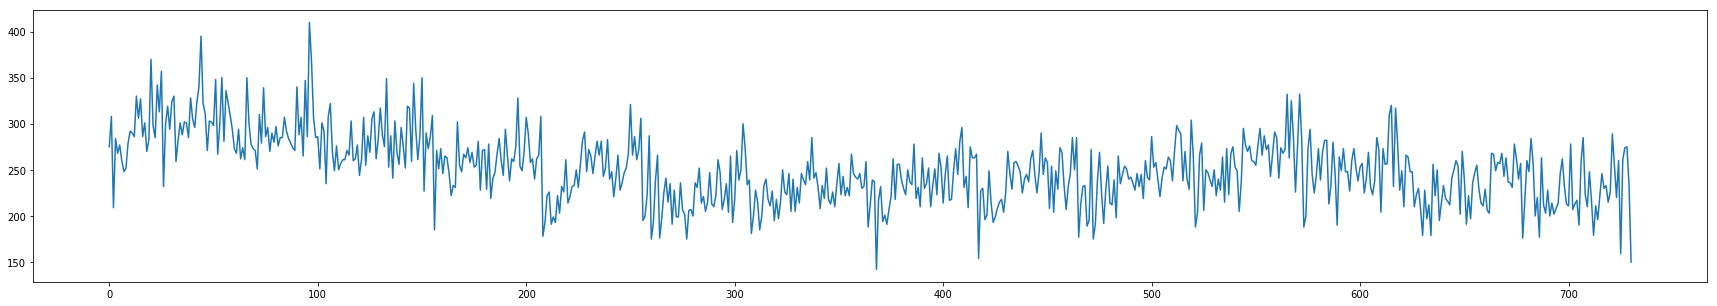

In [6]:
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers.index.values, acc_nr_bw)

#### Windowize and split

In [7]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [8]:
# windowize_data(week_numbers.index.values,20)

In [9]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [69]:
n_prev = 50
x_train, x_test, y_train, y_test = split_and_windowize(acc_nr_bw, n_prev, fraction_test=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((518, 50, 1), (113, 50, 1), (518,), (113,))

In [80]:
split_and_windowize(np.array([1,2,3,4,5,6,7,8,9]), 2,0.01)

(array([[[1],
         [2]],
 
        [[2],
         [3]],
 
        [[3],
         [4]]]), array([[[6],
         [7]],
 
        [[7],
         [8]]]), array([3, 4, 5]), array([8, 9]))

#### Model

In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(120, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

model_def_time = '{}_{}'.format(dt.datetime.now().day,dt.datetime.now().minute)

In [21]:
model.fit(x_train, y_train, batch_size=32, epochs=200)

Train on 575 samples
Epoch 1/200
575/575 [==============================] - 3s 5ms/sample - loss: 880.2955
Epoch 2/200
575/575 [==============================] - 1s 2ms/sample - loss: 841.6743
Epoch 3/200
575/575 [==============================] - 1s 2ms/sample - loss: 894.5671
Epoch 4/200
575/575 [==============================] - 1s 2ms/sample - loss: 831.5356
Epoch 5/200
575/575 [==============================] - 1s 2ms/sample - loss: 839.2260
Epoch 6/200
575/575 [==============================] - 1s 2ms/sample - loss: 827.8812
Epoch 7/200
575/575 [==============================] - 1s 2ms/sample - loss: 851.6814
Epoch 8/200
575/575 [==============================] - 1s 2ms/sample - loss: 832.6744
Epoch 9/200
575/575 [==============================] - 1s 2ms/sample - loss: 841.7992
Epoch 10/200
575/575 [==============================] - 1s 2ms/sample - loss: 833.1340
Epoch 11/200
575/575 [==============================] - 1s 2ms/sample - loss: 839.9481
Epoch 12/200
575/575 [=========

In [22]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[243.0573 ],
       [244.25629],
       [240.17207],
       [232.79424],
       [224.77306]], dtype=float32)

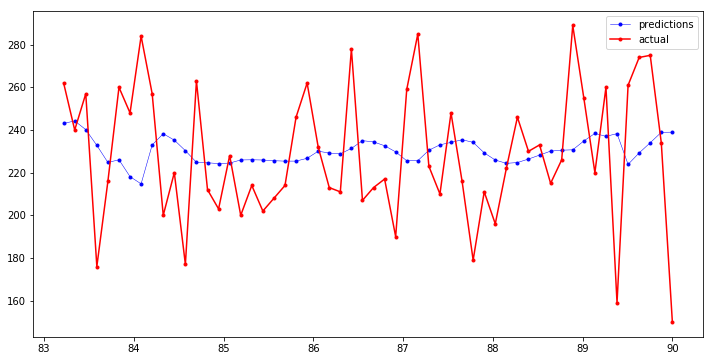

In [23]:
n_pts = len(acc_nr_bw)
# t = np.linspace(0, 15 * 6, n_pts)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.-', label='actual')
ax.legend()
plt.title('LSTM prediction for 2018')

Compared with means of the same period:

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred,y_test)

1108.8661967094106

Comparison to the mean of the previous 56 weeks:

In [34]:
prev_period = acc_nr_bw[-2*len(y_test):-len(y_test)]
baseline_prev = [prev_period.mean()]*len(y_test)
mean_squared_error(baseline_prev,y_test)

1018.2908163265305

Shortening the comparison window:

In [53]:
cutoff=len(y_test)
wl =56
for wl in range(1,20):
    prev_period = acc_nr_bw[-2*cutoff:-cutoff]
    baseline_prev = [prev_period.mean()]*wl
    print(wl,':')
    print('mse base:', mean_squared_error(baseline_prev,y_test[:wl]))
    print('mse pred:', mean_squared_error(y_pred[:wl],y_test[:wl]))

1 :
mse base: 882.9387755102046
mse pred: 358.82600630656816
2 :
mse base: 471.22448979591866
mse pred: 188.4709910537349
3 :
mse base: 517.7482993197282
mse pred: 220.0403656551304
4 :
mse base: 1180.3316326530612
mse pred: 971.4265630670707
5 :
mse base: 997.3102040816326
mse pred: 792.53455287572
6 :
mse base: 959.1054421768707
mse pred: 852.6784829244716
7 :
mse base: 857.3673469387755
mse pred: 858.313504165604
8 :
mse base: 1084.4923469387757
mse pred: 1350.4749120122578
9 :
mse base: 1031.859410430839
mse pred: 1264.4560840562917
10 :
mse base: 1032.9102040816329
mse pred: 1284.3439249432413
11 :
mse base: 952.7309833024119
mse pred: 1188.7067479906943
12 :
mse base: 1128.0459183673468
mse pred: 1326.461779271175
13 :
mse base: 1113.8398744113028
mse pred: 1336.4214763053371
14 :
mse base: 1063.673469387755
mse pred: 1252.3911195310563
15 :
mse base: 1049.938775510204
mse pred: 1198.968616370717
16 :
mse base: 985.4655612244898
mse pred: 1124.8027335980441
17 :
mse base: 988.812

In [47]:
y_pred[:wl]

array([[243.0573 ],
       [244.25629],
       [240.17207],
       [232.79424],
       [224.77306],
       [226.03828],
       [218.13156],
       [214.7497 ],
       [232.99364],
       [238.25356],
       [235.24254],
       [230.30823],
       [224.84325],
       [224.64897],
       [224.23802],
       [224.4908 ],
       [225.95058],
       [226.03038],
       [225.93086],
       [225.59596],
       [225.39868],
       [225.41469],
       [226.734  ],
       [230.0436 ],
       [229.20734],
       [228.81625],
       [231.35988],
       [234.99748],
       [234.42451],
       [232.61716],
       [229.73698],
       [225.57741],
       [225.61287],
       [230.50877],
       [233.05104],
       [234.17961],
       [235.43605],
       [234.20715],
       [229.28465],
       [225.9167 ],
       [224.36295],
       [224.7363 ],
       [226.38039],
       [228.22731],
       [230.09828],
       [230.52446],
       [230.71368],
       [234.85072],
       [238.38942],
       [237.02036],


In [40]:
# cutoff=len(y_test)
# for i in range(1,cutoff):
#     prev_period = acc_nr_bw[-(cutoff+i):-cutoff]
#     baseline_prev = [prev_period.mean()]*i
#     print(mean_squared_error(baseline_prev,y_test[:i]))

Text(0.5, 0, 'epoch')

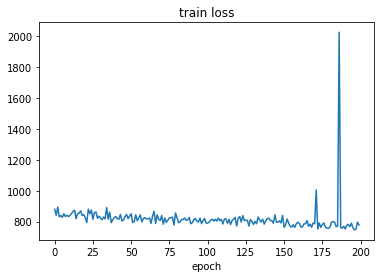

In [25]:
history = model.history
plt.title("train loss")
plt.plot( history.history["loss"] )
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

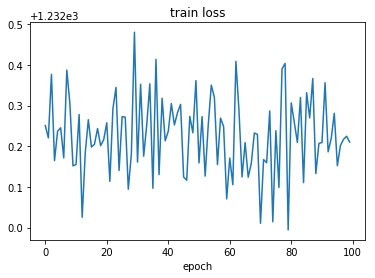

In [19]:
history = model.history
plt.title("train loss")
plt.plot( history.history["loss"][200:] )
plt.xlabel("epoch")

In [18]:
filename = 'models/lstm_8_{}'.format(model_def_time)
model.save(filename, overwrite=False)

[WARNING] models/lstm_8_24_59 already exists - overwrite? [y/n]n


#### baselines

In [19]:
baseline_mean = [y_test.mean()]*56
mean_squared_error(baseline_mean,y_test)

1002.5752551020408

In [62]:
expl=[0,1,2,3,4,5,6,7,8,9]

In [67]:
split_and_windowize(expl, 1, fraction_test=.1)

TypeError: list indices must be integers or slices, not tuple